# Resolviendo diversidad de tareas con RNNs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_2/notebooks/Nb_2b_Resolviendo_desafios_con_RNNs_usando_keras.ipynb)

In [8]:
#@title Importar librerías
#importar librerías necesarias
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf

In [137]:
#@title Funciones complementarias

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_variables(df, date_time):
    plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
    plot_features = df[plot_cols]
    plot_features.index = date_time
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:480]
    plot_features.index = date_time[:480]
    _ = plot_features.plot(subplots=True)



def read_dataset_clima():

    zip_path = tf.keras.utils.get_file(
        origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
        fname='jena_climate_2009_2016.csv.zip',
        extract=True)
    csv_path, _ = os.path.splitext(zip_path)

    df = pd.read_csv(csv_path)
    # Slice [start:stop:step], starting from index 5 take every 6th record.
    df = df[5::6]

    date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

    return df, date_time

def split_data(df):
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]

    return train_df, val_df, test_df, num_features, column_indices

def normalizacion_datos(train_df, val_df, test_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, val_df, test_df


class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



WindowGenerator.plot = plot
WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Escenarios de uso de las redes neuronales recurrentes.

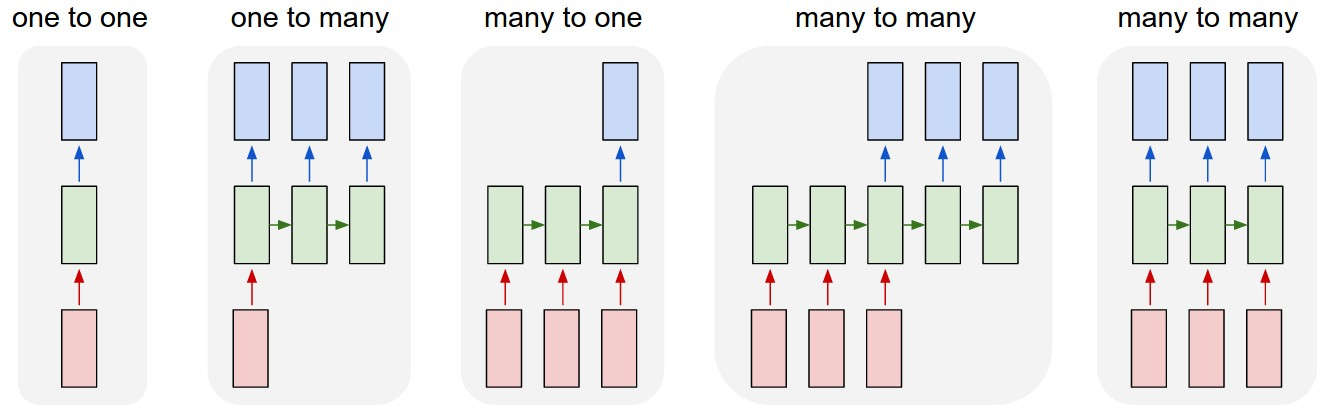

## Clasificación de texto usando RNNs (Relación muchas entradas a una salida)

En este escenario se reciben multiples entradas pero solo se genera una salida. Aquí podemos abordar el ejemplo más común que es la clasificación de texto.


### Descargar el dataset de reviews de peliculas usando Tensorflow.

El gran conjunto de datos de críticas de películas de IMDB es un conjunto de datos de clasificación binaria: todas las críticas tienen un sentimiento positivo o negativo.

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UEXMOY_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UEXMOY_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UEXMOY_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [16]:
# contar cuantas muestras tiene train_dataset y test_dataset
print(info.splits)

{Split('train'): <SplitInfo num_examples=25000, num_shards=1>, Split('test'): <SplitInfo num_examples=25000, num_shards=1>, Split('unsupervised'): <SplitInfo num_examples=50000, num_shards=1>}


In [3]:
# extraer una muestra del conjunto de entrenamiento
train_example, train_label = next(iter(train_dataset.batch(1)))

print('Para la etiqueta: {} se tiene el texto: {}'.format(train_label, train_example.numpy()))

Para la etiqueta: [0] se tiene el texto: [b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."]


Las siguientes lineas son para optimizar los conjuntos y que el entrenamiento sea más acelerado.

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

# optimización para train
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# optimización para test
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
# muestras para el conjunto de test
for ejemplo, label in test_dataset.take(1):
  print('textos: ', ejemplo.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


textos:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden pries

### Pre-procesamiento y modelado.

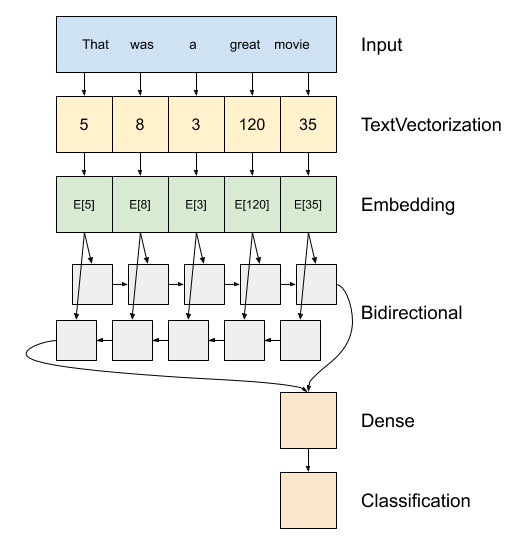

**Explicación del modelo:**

Este modelo se puede construir como un tf.keras.Sequential.

1. La primera capa (amarilla) es el codificador, que convierte el texto en una secuencia de índices de tokens.

2. Después del codificador hay una capa de embedding (verde). Una capa de embedding almacena un vector por palabra. Cuando se llama, convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores son entrenables. Después del entrenamiento (con suficientes datos), las palabras con significados similares a menudo tienen vectores similares.

3. Una red neuronal recurrente (RNN) procesa la entrada secuencial iterando a través de los elementos. Las RNN pasan las salidas de un instante de tiempo a su entrada en el siguiente instante de tiempo.

4. La capa tf.keras.layers.Bidirectional también se puede usar con una capa RNN. Esto propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.
    * La principal ventaja de una RNN bidireccional es que la señal desde el comienzo de la entrada no necesita ser procesada a lo largo de cada instante de tiempo para afectar la salida.

    * La principal desventaja de una RNN bidireccional es que no se pueden transmitir predicciones de manera eficiente a medida que se agregan palabras al final.

5. Después de que la RNN ha convertido la secuencia en un solo vector, las dos capas Dense realizan un procesamiento final y convierten esta representación vectorial en un solo valor como salida de clasificación.

#### Capa Codificador (Text Vectorization)

El texto sin procesar cargado por tfds necesita ser procesado antes de que pueda ser utilizado en un modelo. La forma más sencilla de procesar texto para el entrenamiento es utilizando la capa TextVectorization.

Explicación:

La capa TextVectorization es una herramienta en TensorFlow que transforma texto sin procesar en una representación numérica que los modelos de aprendizaje automático pueden entender. Convierte las palabras en vectores, lo que facilita el entrenamiento del modelo. Esto incluye tareas como:

* Tokenización: Dividir el texto en palabras o subpalabras.
* Normalización: Convertir todo el texto a minúsculas, eliminar caracteres especiales, etc.
* Vectorización: Asignar un índice o valor numérico a cada palabra o token, lo que permite representarlo como una matriz numérica.

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Crea la capa y pasa el texto del conjunto de datos al método .adapt de la capa
encoder.adapt(train_dataset.map(lambda text, label: text))

El método .adapt se utiliza para "entrenar" la capa en el conjunto de datos de texto. Esto significa que la capa analizará el texto y aprenderá el vocabulario, así como otras características (como la frecuencia de las palabras) que serán útiles para la vectorización

In [7]:
# revisar los primeros 20 elementos del vocabulario creado
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Una vez que el vocabulario está establecido, la capa puede codificar el texto en índices. Los tensores de índices se rellenan con ceros hasta la secuencia más larga en el batch (a menos que establezcas una longitud de salida fija).

In [8]:
encoded_ejemplo = encoder(ejemplo)[:3].numpy()
encoded_ejemplo

array([[ 48,  24,  95, ...,   0,   0,   0],
       [  4,   1, 723, ...,   0,   0,   0],
       [633,  18,   1, ...,  18,   1,   1]])

In [9]:
# Visualizamos algunas imágenes
for n in range(3):
  print("Original: ", ejemplo[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_ejemplo[n]]))
  print()


Original:  b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
Round-trip:  there are films that make [UNK] f

#### Creación del modelo usando keras

In [23]:
'''model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Se ignora los valores en 0
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), merge_mode='concat'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])'''

def rnn():
    # Ahora utilizamos la API funcional de Keras
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)  # El input será una cadena de texto
    x = encoder(inputs)  # Aplicamos el encoder

    x = tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True)(x)  # Capa de Embedding

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), merge_mode='concat')(x)  # Capa LSTM Bidireccional

    x = tf.keras.layers.Dense(64, activation='relu')(x)  # Capa densa
    outputs = tf.keras.layers.Dense(1)(x)  # Capa de salida

    # Definimos el modelo
    model = tf.keras.Model(inputs, outputs)

    return model

# crear la red RNN
model = rnn()

# Compilamos el modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Verificamos la estructura del modelo
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, None)           │              0 │ input_layer_2[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 64)       │         64,000 │ text_vectorization[2]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ text_vectorization[2]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 128)            │         66,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 138,369 (540.50 KB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

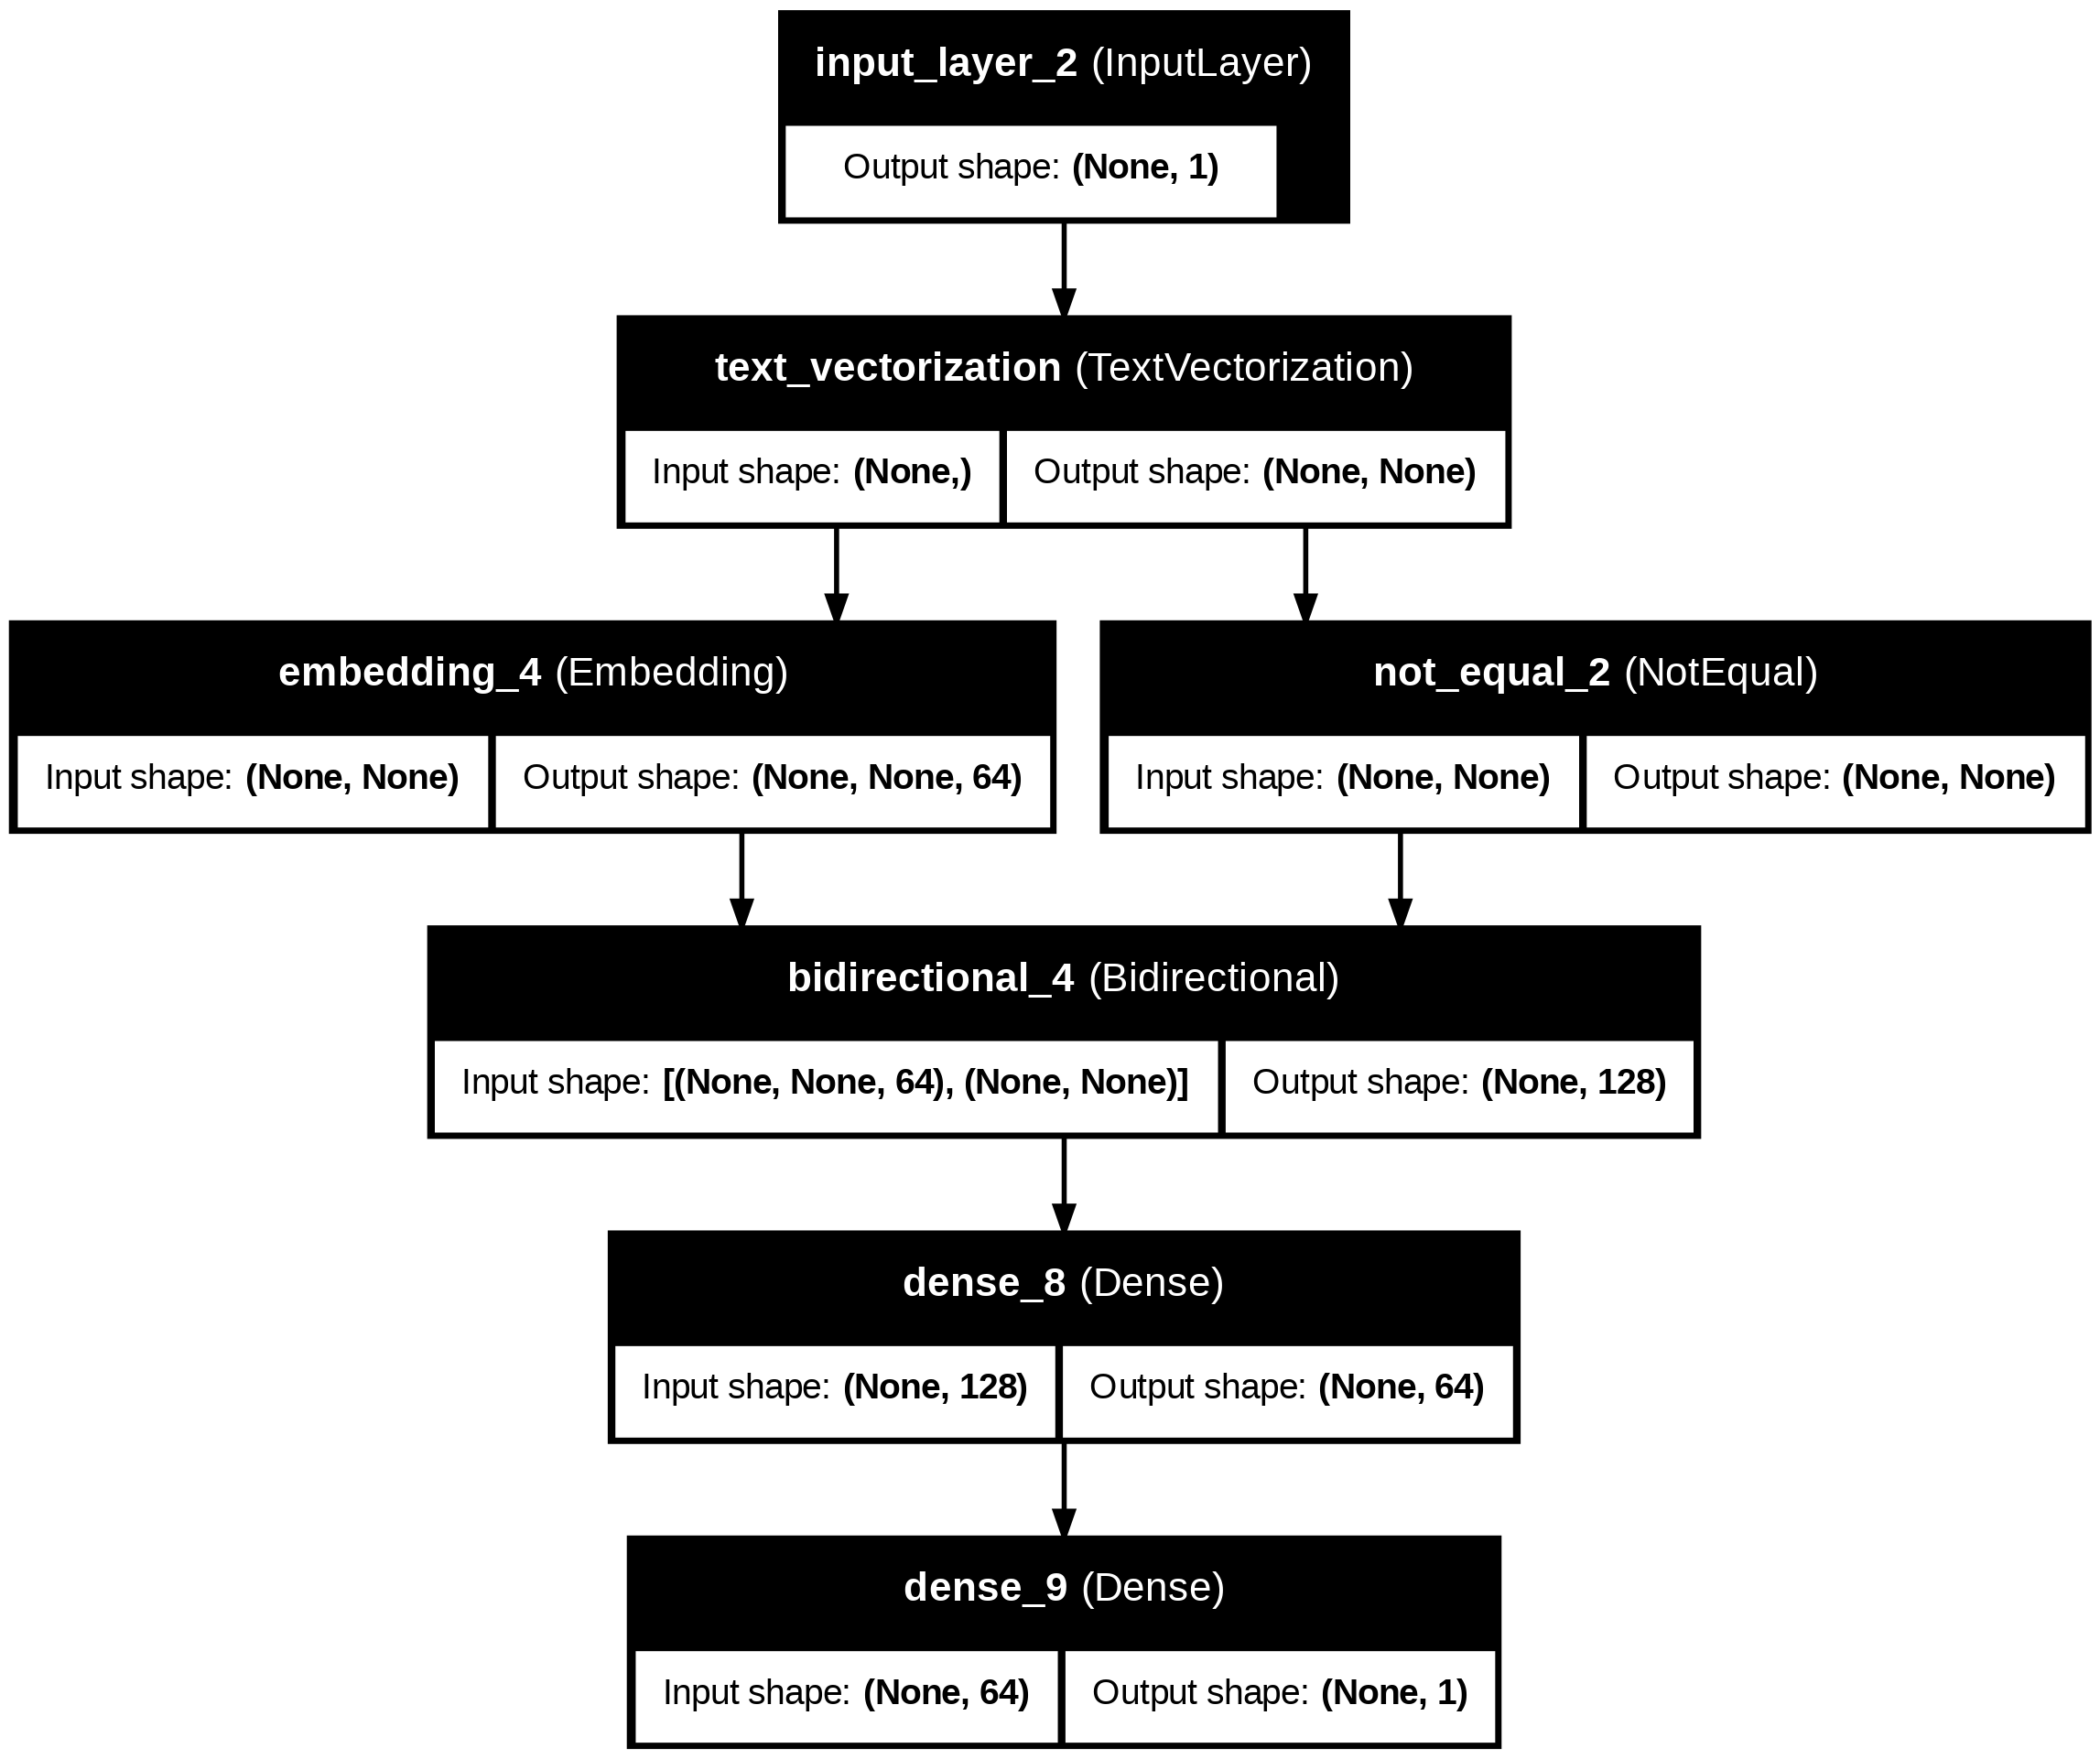

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
# hacer una prueba sin usar padding
# El texto crudo que quieres predecir
sample_text = ('The movie was cool. The animation and the graphics were out of this world.')

# No es necesario hacer la vectorización manual aquí, simplemente pasa el texto crudo al modelo
predictions = model.predict(tf.constant([sample_text]))

# Imprime la predicción
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
[-0.00120403]


In [26]:
# prueba ahora usando padding
# debe dar el mismo resultado
padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[-0.00120403]


#### Entrenamiento y evaluación del modelo

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5446 - loss: 0.6621 - val_accuracy: 0.7406 - val_loss: 0.4787
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.8113 - loss: 0.4087 - val_accuracy: 0.8531 - val_loss: 0.3368
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.8475 - loss: 0.3460 - val_accuracy: 0.8583 - val_loss: 0.3476
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.8518 - loss: 0.3369 - val_accuracy: 0.8385 - val_loss: 0.3222
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.8585 - loss: 0.3212 - val_accuracy: 0.8448 - val_loss: 0.3103
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.8657 - loss: 0.3102 - val_accuracy: 0.8833 - val_loss: 0.3025
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8650 - loss: 0.3053 - val_accuracy: 0.8417 - val_loss: 0.3308
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.8643 - loss: 0.3065 - 

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8611 - loss: 0.3154
Test Loss: 0.3137839138507843
Test Accuracy: 0.8598799705505371


(0.0, 0.6139567941427231)

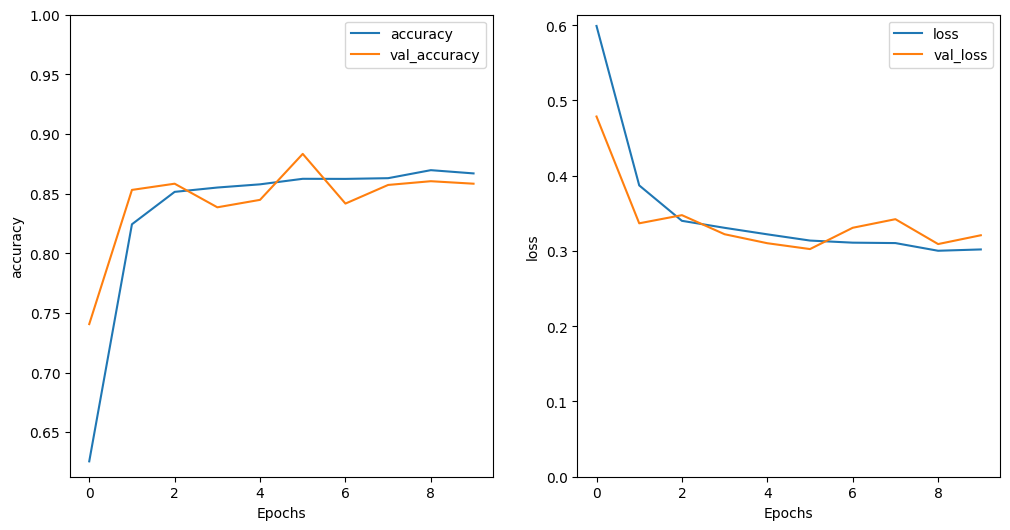

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [31]:
# realizar una predicción des pues de entrenar
sample_text = ('The movie was cool. The animation and the graphics were out of this world.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.2081792]]


**Cómo podríamos agregar más capas LSTM para aumentar la complejidad del modelo?**

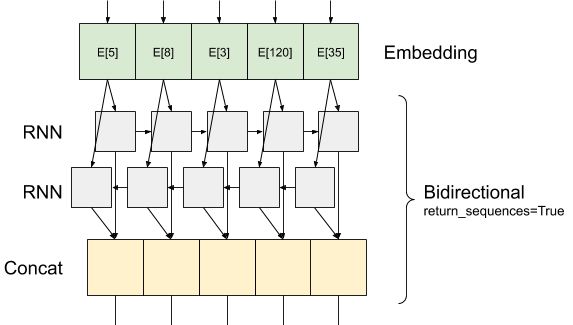

Las capas recurrentes de Keras tienen dos modos disponibles que son controlados por el argumento del constructor return_sequences:

* Si es False devuelve sólo la última salida para cada secuencia de entrada (un tensor 2D de forma (batch_size, output_features)). Este es el valor por defecto, utilizado en el modelo anterior.

* Si es True se devuelven las secuencias completas de salidas sucesivas para cada paso de tiempo (un tensor 3D de forma (batch_size, timesteps, output_features)).



```
# model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

```



# Una o múltiples predicciones en el futuro usando LSTM con múltiples entradas.

En este ejercicio vamos a trabajar con series temporales. El objetivo es recibir múltiples entradas (ejemplo últimas 24 mediciones de temperatura a nivel de hora) y producir ya sea una o múltiples predicciones en el futuro. Para lograr esto, lo más importante es las ventanas de datos con los que se entrenan las redes recurrentes.

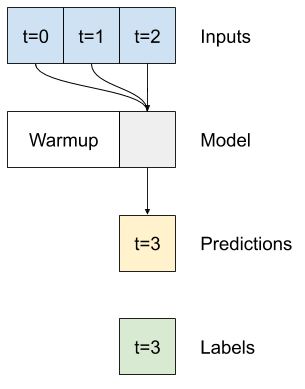

## Leer datos

In [121]:
df, date_time = read_dataset_clima()

In [122]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [123]:
date_time

,Date Time
5,2009-01-01 01:00:00
11,2009-01-01 02:00:00
17,2009-01-01 03:00:00
23,2009-01-01 04:00:00
29,2009-01-01 05:00:00
...,...
420521,2016-12-31 19:10:00
420527,2016-12-31 20:10:00
420533,2016-12-31 21:10:00
420539,2016-12-31 22:10:00


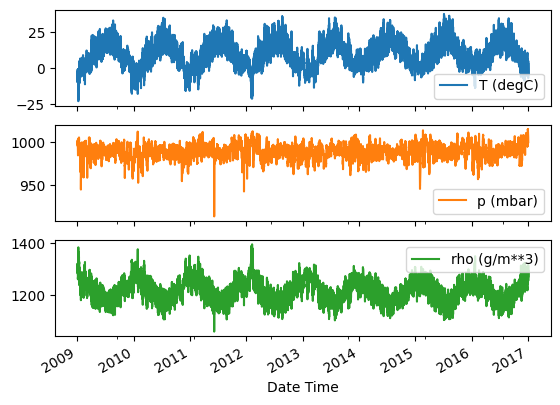

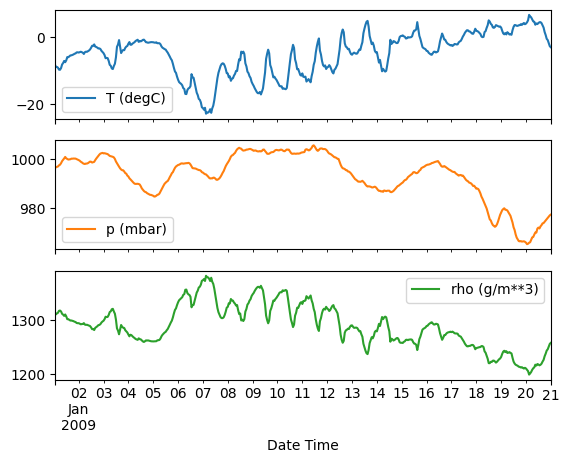

In [124]:
plot_variables(df, date_time)

In [125]:
train_df, val_df, test_df, num_features, column_indices = split_data(df)
train_df.shape, val_df.shape, test_df.shape

((49063, 14), (14018, 14), (7010, 14))

In [126]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [127]:
train_df, val_df, test_df = normalizacion_datos(train_df, val_df, test_df)
train_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,49063.000000,4.906300e+04,49063.000000,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04
mean,2.027515e-16,-1.946415e-16,9.685730e-16,1.853728e-17,-6.719765e-16,0.000000,-2.270817e-16,0.000000,-1.506154e-16,1.807385e-16,-2.321795e-15,1.540912e-16,-1.616219e-16,-2.178131e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.045695e+00,-3.682079e+00,-3.707266e+00,-4.216645e+00,-3.746587e+00,-1.609554,-2.030996e+00,-0.829861,-2.022853e+00,-2.031986e+00,-3.846513e+00,-1.403684e+00,-1.535423e+00,-1.977937e+00
25%,-6.093840e-01,-7.069026e-01,-6.939982e-01,-6.697392e-01,-6.581569e-01,-0.750526,-7.786971e-01,-0.657581,-7.762466e-01,-7.761335e-01,-7.116941e-01,-7.390786e-01,-7.595612e-01,-6.326198e-01
50%,5.467421e-02,9.450477e-03,1.318575e-02,5.168967e-02,1.989686e-01,-0.222892,-1.561120e-01,-0.383594,-1.548152e-01,-1.540757e-01,-7.847992e-02,-2.308512e-01,-2.250786e-01,2.674928e-01
75%,6.548575e-01,7.200265e-01,7.123465e-01,7.530390e-01,8.150841e-01,0.533469,6.684569e-01,0.268164,6.650251e-01,6.651626e-01,6.442168e-01,4.793641e-01,5.206108e-01,6.932912e-01
max,2.913378e+00,3.066661e+00,3.041354e+00,2.647686e+00,1.455361e+00,5.846190,4.489514e+00,7.842254,4.550843e+00,4.524268e+00,4.310438e+00,7.724863e+00,8.593884e+00,2.131645e+00


## Creación de ventanas

Ejemplo para un problema que dado las últimas 6 mediciones de temperatura va a predecir la siguiente hora de temperatura.

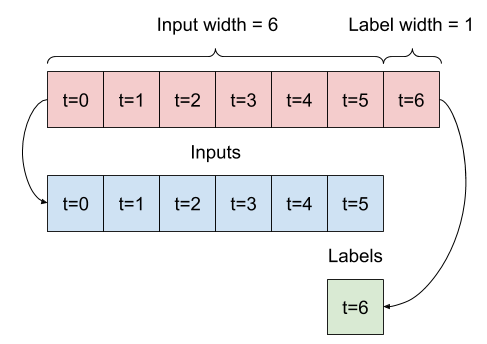

### Ejemplo creación dataset ventanas

In [128]:
# Crear un array de 15 minutos y 3 características (features), con valores consecutivos para facilitar el entendimiento
datae = np.arange(10 * 3).reshape(10, 3)

# Crear un DataFrame para mostrar los datos de manera más clara
dfe = pd.DataFrame(datae, columns=['Feature_1', 'Feature_2', 'Target'])
dfe.index.name = 'Minuto'

# Mostrar el DataFrame
dfe

,Feature_1,Feature_2,Target
Minuto,,,
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11
4,12,13,14
5,15,16,17
6,18,19,20
7,21,22,23
8,24,25,26


In [129]:
# La variable a predecir es la última columna (columna final)
targets = datae[2:, -1]  # Los targets son el valor de la columna final (variable a predecir) desplazados por 2 pasos
targets

array([ 8, 11, 14, 17, 20, 23, 26, 29])

In [130]:
# Crear el dataset de series temporales
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=datae[:-1],  # Todas las filas menos la última, porque no hay target para la última fila
    targets=targets,  # Los valores a predecir son la columna final de la siguiente fila
    sequence_length=2,  # Usamos secuencias de 6 minutos
    sequence_stride=1,  # Stride de 1 para obtener todas las posibles ventanas
    shuffle=False,  # Barajamos las secuencias
    batch_size=2  # Agrupamos en lotes de 2 secuencias
)

In [131]:
# Mostrar los primeros 5 lotes de inputs y labels, con un formato mejorado
for batch_num, batch in enumerate(ds.take(5), 1):
    inputs, labels = batch
    print(f"Batch {batch_num}:")
    print(f"Inputs shape: {inputs.shape}")
    print("Inputs:")

    # Imprimir cada secuencia de inputs con su respectiva etiqueta al final
    for i, (input_sequence, label) in enumerate(zip(inputs.numpy(), labels.numpy()), 1):
        print(f"  Sequence {i}:")
        print(f" {input_sequence} -> Target: {label}")

    print("\n" + "-"*50 + "\n")

Batch 1:
Inputs shape: (2, 2, 3)
Inputs:
  Sequence 1:
 [[0 1 2]
 [3 4 5]] -> Target: 8
  Sequence 2:
 [[3 4 5]
 [6 7 8]] -> Target: 11

--------------------------------------------------

Batch 2:
Inputs shape: (2, 2, 3)
Inputs:
  Sequence 1:
 [[ 6  7  8]
 [ 9 10 11]] -> Target: 14
  Sequence 2:
 [[ 9 10 11]
 [12 13 14]] -> Target: 17

--------------------------------------------------

Batch 3:
Inputs shape: (2, 2, 3)
Inputs:
  Sequence 1:
 [[12 13 14]
 [15 16 17]] -> Target: 20
  Sequence 2:
 [[15 16 17]
 [18 19 20]] -> Target: 23

--------------------------------------------------

Batch 4:
Inputs shape: (2, 2, 3)
Inputs:
  Sequence 1:
 [[18 19 20]
 [21 22 23]] -> Target: 26
  Sequence 2:
 [[21 22 23]
 [24 25 26]] -> Target: 29

--------------------------------------------------



### Retomando

In [132]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [133]:
WIDTH_TEMP = 6
window = WindowGenerator(
    input_width=WIDTH_TEMP,
    label_width=1,
    shift=1,
    train_df = train_df,
    val_df = val_df,
    test_df=test_df,
    label_columns=['T (degC)'])

window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [134]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
Labels shape: (3, 1, 1)


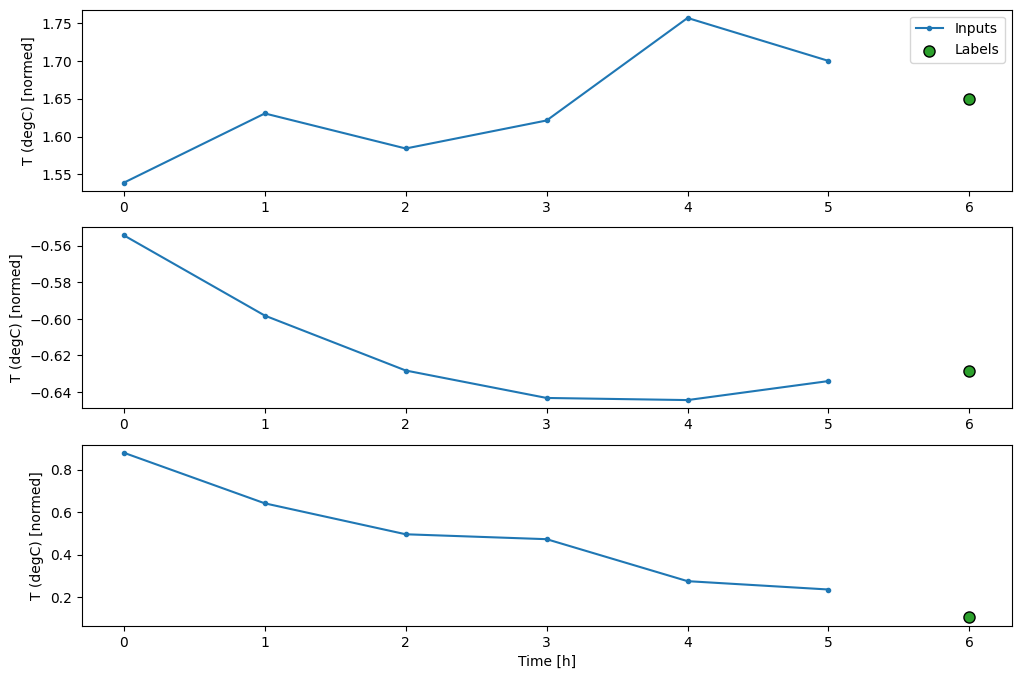

In [56]:
# graficar los datos en las ventanas
window.plot()

In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [58]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)

Input shape: (32, 6, 14)
Output shape: (32, 6, 1)


In [59]:
history = compile_and_fit(lstm_model, window)

val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0, return_dict=True)


Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.1702 - mean_absolute_error: 0.2857 - val_loss: 0.0806 - val_mean_absolute_error: 0.2000
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0796 - mean_absolute_error: 0.1978 - val_loss: 0.0805 - val_mean_absolute_error: 0.2008
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0759 - mean_absolute_error: 0.1912 - val_loss: 0.0750 - val_mean_absolute_error: 0.1902
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0727 - mean_absolute_error: 0.1861 - val_loss: 0.0742 - val_mean_absolute_error: 0.1871
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0720 - mean_absolute_error: 0.1845 - val_loss: 0.0732 - val_mean_absolute_error: 0.1869
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0705 - mean_absolute_error: 0.1822 - val_loss: 0.0728 - val_mean_absolute_error: 0.1857
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0698 - mean_absol

In [115]:
performance

{'LSTM': {'loss': 0.0691012442111969,
  'mean_absolute_error': 0.18326018750667572}}

In [116]:
val_performance

{'LSTM': {'loss': 0.07278452813625336,
  'mean_absolute_error': 0.1851218044757843}}